In [1]:
import requests
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score 
import math
import seaborn as sns
import shutil

In [2]:
# odk data for the evaluation and testing data 
media_path = "/Users/edwardamoah/Documents/GitHub/pv_mrv/statistical_analysis/data/odk_data/media"
trees_path = "/Users/edwardamoah/Documents/GitHub/pv_mrv/statistical_analysis/data/odk_data/Tree-Segmentation-tree.csv"
surveys_path = "/Users/edwardamoah/Documents/GitHub/pv_mrv/statistical_analysis/data/odk_data/Tree-Segmentation.csv"

In [3]:
trees = pd.read_csv(trees_path)
trees.head()

,tree_height,tree_dbh,dbh_picture,tree_picture,tagged,PARENT_KEY,KEY
0,1675934352599.jpg,38.5,1675934420893.jpg,1675934453966.jpg,True,uuid:dd297526-8c25-4739-bd7b-da6f60ff5af8,uuid:dd297526-8c25-4739-bd7b-da6f60ff5af8/tree[1]
1,1675934663170.jpg,37.6,1675934751321.jpg,1675934772605.jpg,True,uuid:dd297526-8c25-4739-bd7b-da6f60ff5af8,uuid:dd297526-8c25-4739-bd7b-da6f60ff5af8/tree[2]
2,NaN,30.0,1675927406327.jpg,1675927458697.jpg,True,uuid:36348ace-73e5-470a-a5c4-5840313cbda3,uuid:36348ace-73e5-470a-a5c4-5840313cbda3/tree[1]
3,NaN,36.1,1675927574456.jpg,1675927603450.jpg,True,uuid:36348ace-73e5-470a-a5c4-5840313cbda3,uuid:36348ace-73e5-470a-a5c4-5840313cbda3/tree[2]
4,NaN,30.3,1675927703794.jpg,1675927823347.jpg,True,uuid:36348ace-73e5-470a-a5c4-5840313cbda3,uuid:36348ace-73e5-470a-a5c4-5840313cbda3/tree[3]


In [4]:
surveys = pd.read_csv(surveys_path)
surveys.head()

,SubmissionDate,meta-instanceID,tape,KEY,SubmitterID,SubmitterName,AttachmentsPresent,AttachmentsExpected,Status,ReviewState,DeviceID,Edits,FormVersion
0,2023-02-09T09:29:04.134Z,uuid:dd297526-8c25-4739-bd7b-da6f60ff5af8,diameter,uuid:dd297526-8c25-4739-bd7b-da6f60ff5af8,2288,Edna Santa,6,6,NaN,approved,collect:Vj0q9GQP0zqbfLwF,0,1661527221
1,2023-02-09T07:31:13.315Z,uuid:36348ace-73e5-470a-a5c4-5840313cbda3,diameter,uuid:36348ace-73e5-470a-a5c4-5840313cbda3,697,Chelsea,6,6,NaN,approved,collect:mL5vu2SFBbwzPFid,0,1661527221
2,2023-02-09T07:23:00.751Z,uuid:aaa40b2f-2e00-468a-ab82-6b469c450b9f,diameter,uuid:32c56ff4-e7d5-4371-ade8-8f780843c3d0,697,Chelsea,16,16,NaN,approved,collect:mL5vu2SFBbwzPFid,1,1661527221
3,2023-02-08T13:10:28.964Z,uuid:aa6aedb8-d5d5-47ce-a31b-e0195ddde8b6,diameter,uuid:aa6aedb8-d5d5-47ce-a31b-e0195ddde8b6,2020,Nancy Titus,12,12,NaN,approved,collect:6Li3ZoyXMyhwZv6V,0,1661527221
4,2023-02-08T09:44:41.605Z,uuid:b369384c-d68e-4f3f-9988-00f1d1112411,diameter,uuid:b369384c-d68e-4f3f-9988-00f1d1112411,1424,Maureen Kalegi,3,3,NaN,approved,collect:pPniH3MXpCFPaExY,0,1661527221


In [5]:
# filter surveys that were approved on odk central panel
testing_keys = surveys[surveys['ReviewState'] == 'approved']["KEY"].tolist()

def getTestingDataset(parent_key):
    if parent_key in testing_keys:
        return True
    else:
        return False

testing_trees = trees[trees.PARENT_KEY.apply(getTestingDataset)]

In [6]:
# number of images for testing 
tree_pictures = testing_trees['tree_picture'].tolist()
len(tree_pictures)

206

In [7]:
# Confirm which survey images are available for analysis
downloaded_images = []
for image in tree_pictures:
    if image in os.listdir(media_path):
        downloaded_images.append(image)

In [8]:
# generate complete path for tree images that exist
downloaded_image_paths = [os.path.join(media_path, image) for image in downloaded_images]

In [9]:
# functions to get dbh estimation for an image. The dbh estimation algorithm FastAPI must be running locally. 

def getDBH(temp_image, measured_dbh):
    try:

        url = f'http://127.0.0.1:8000/recognize/{measured_dbh}'

        file = {'uploaded_file': open(temp_image, 'rb')}

        r = requests.post(url, files=file)

        dbh = eval(r.text)['dbh']

        return dbh
        
    except:
        return None

In [10]:
# make a new dataframe with tree picture, and its location
df = pd.DataFrame({
    'tree_picture': downloaded_images,
    'image_path': downloaded_image_paths
})

In [11]:
# merge the dataframe from above with the orginal dataset to add the measured_dbh values
df= df.merge(trees[['tree_picture', 'tree_dbh', 'PARENT_KEY']], on='tree_picture')
df.head()

,tree_picture,image_path,tree_dbh,PARENT_KEY
0,1675934453966.jpg,/Users/edwardamoah/Documents/GitHub/pv_mrv/sta...,38.5,uuid:dd297526-8c25-4739-bd7b-da6f60ff5af8
1,1675934772605.jpg,/Users/edwardamoah/Documents/GitHub/pv_mrv/sta...,37.6,uuid:dd297526-8c25-4739-bd7b-da6f60ff5af8
2,1675927458697.jpg,/Users/edwardamoah/Documents/GitHub/pv_mrv/sta...,30.0,uuid:36348ace-73e5-470a-a5c4-5840313cbda3
3,1675927603450.jpg,/Users/edwardamoah/Documents/GitHub/pv_mrv/sta...,36.1,uuid:36348ace-73e5-470a-a5c4-5840313cbda3
4,1675927823347.jpg,/Users/edwardamoah/Documents/GitHub/pv_mrv/sta...,30.3,uuid:36348ace-73e5-470a-a5c4-5840313cbda3


In [12]:
# standardized dbh measurements. Some of the measurements were done with standard tape and others with diameter tapes. Make them all a diameter measurement
diameter = surveys[surveys['tape'] == 'diameter']['KEY'].tolist()
standard = surveys[surveys['tape'] == 'standard']['KEY'].tolist()


def getTape(parent_key):
    if parent_key in diameter:
        return "diameter"
    elif parent_key in standard:
        return "standard"
    else:
        return None

df['tape'] = df["PARENT_KEY"].apply(getTape)

def getMeasuredDBH(tree_dbh, tape):
    if tape == 'diameter':
        return tree_dbh
    elif tape == 'standard':
        return round(tree_dbh/math.pi, 2)
    else:
        return None

df['measured_dbh'] = df.apply(lambda x: getMeasuredDBH(x['tree_dbh'],x['tape']), axis=1)


In [13]:
# helper function to group data into buckets for dbh ranges
def getRange(dbh):
    if dbh < 5:
        return "0-05"
    elif dbh < 10:
        return "05-10"
    elif dbh < 15:
        return "10-15"
    elif dbh < 20:
        return "15-20"
    elif dbh < 25:
        return "20-25"
    elif dbh < 30:
        return "25-30"
    elif dbh < 35:
        return "30-35"
    elif dbh < 40:
        return "35-40"
    elif dbh < 45:
        return "40-45"
    elif dbh > 45:
        return "45+"


In [14]:
# apply helper function above on the measured dbh values
df['range'] = df.measured_dbh.apply(getRange)

In [15]:
# drop out dataset with no submission for tree image, or actual dbh measurement
df = df.dropna()
len(df)

205

Text(0, 0.5, 'Frequency')

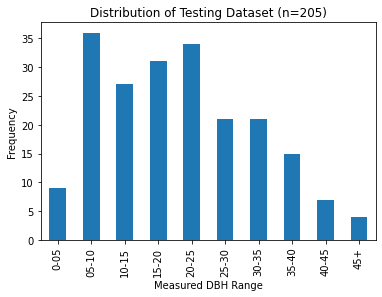

In [16]:
# Distribution of dataset
df.groupby('range').count()['tree_picture'].plot.bar()
plt.title(f'Distribution of Testing Dataset (n={len(df)})')
plt.xlabel("Measured DBH Range")
plt.ylabel("Frequency")

In [17]:
# This doesn't do anything important. I used it before to do some sampling experiments
df_sample = df #.sample(n=170) # sub-sample
#len(df_sample)

In [18]:
# filter out calibiration dataset 
# load file names of images that were used for calibrating the model to seperate them from the evaluation of the model
calibiration = os.listdir('/Users/edwardamoah/Documents/GitHub/pv_mrv/statistical_analysis/data/annotated_trees')
calibiration = [val for val in calibiration if "zoomed" in val]
calibiration = [val.split("_")[3]+".jpg" for val in calibiration]
len(calibiration)
# there are 52 images that were used for calibiration

52

In [19]:
# function to check if an image is in the calibration dataset
def isCalibirationData(tree_pic):
    if tree_pic in calibiration:
        return True
    return False

def isNotCalibirationData(tree_pic):
    return not isCalibirationData(tree_pic)

Text(0, 0.5, 'Frequency')

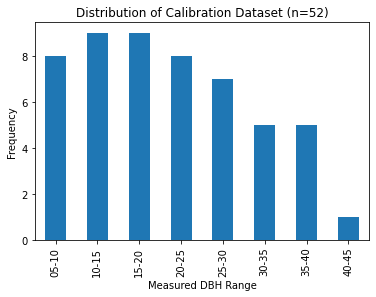

In [20]:
# Make a plot for the distribution of the calibration dataset
t = df_sample[ df_sample["tree_picture"].apply(isCalibirationData)]
t.groupby('range').count()['tree_picture'].plot.bar()
plt.title(f'Distribution of Calibration Dataset (n={len(t)})')
plt.xlabel("Measured DBH Range")
plt.ylabel("Frequency")

In [21]:
df_sample = df_sample[df_sample["tree_picture"].apply(isNotCalibirationData)] # filter out calibration dataset

In [22]:
# filter out dataset where measured dbh < 5
df_sample = df_sample[df_sample["measured_dbh"]>=5]
len(df_sample)

144

In [23]:
# Get dbh predictions for all dataset 
df_sample['predicted_dbh'] = df_sample.apply(lambda x: getDBH(x['image_path'], x['measured_dbh']), axis=1)

In [24]:
# function to check if a prediction was made 
def isfloat(x):
    return type(x) == float

In [25]:
# check that a prediction was made for each image
df_sample['calculated'] = df_sample['predicted_dbh'].apply(isfloat)

In [26]:
# count t
df_sample[df_sample['calculated'] == False].groupby('predicted_dbh').count()
# the algorithm made a prediction for all the images

,tree_picture,image_path,tree_dbh,PARENT_KEY,tape,measured_dbh,range,calculated
predicted_dbh,,,,,,,,


In [27]:
df_sample[df_sample['calculated'] == False]

,tree_picture,image_path,tree_dbh,PARENT_KEY,tape,measured_dbh,range,predicted_dbh,calculated


In [28]:
df1 = df_sample[df_sample['predicted_dbh'].apply(isfloat)]
#df1 = df1[df1['range'] != '0-05'] # remove less than 5 cm 
#df1 = df1[df1['range'] != '45+'] # remove above 45+ cm
len(df1)

144

In [29]:
# distribution of prediction dbh range
df1.groupby('range').count()

,tree_picture,image_path,tree_dbh,PARENT_KEY,tape,measured_dbh,predicted_dbh,calculated
range,,,,,,,,
05-10,28,28,28,28,28,28,28,28
10-15,18,18,18,18,18,18,18,18
15-20,22,22,22,22,22,22,21,22
20-25,26,26,26,26,26,26,26,26
25-30,14,14,14,14,14,14,14,14
30-35,16,16,16,16,16,16,16,16
35-40,10,10,10,10,10,10,10,10
40-45,6,6,6,6,6,6,6,6
45+,4,4,4,4,4,4,4,4


In [30]:
# drop dataset with nan
df1 = df1.dropna()
len(df1)

143

In [31]:
# Calculate error percentage
def getErrorPercentage(predicted, measured):
    return (abs(predicted - measured)/measured) * 100

df1['Error_percentage'] = df1.apply(lambda x: getErrorPercentage(x['predicted_dbh'], x['measured_dbh']), axis=1)

In [32]:
# filter out dataset where trees were too small (i.e < 5cm)
df2 = df1[df1['measured_dbh'] > 5]
len(df1)

143

(array([103]),)


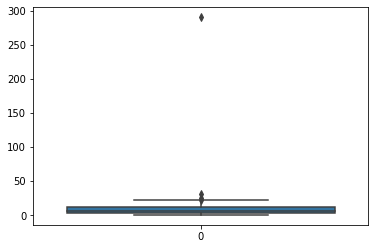

In [33]:
#Remove outliers based on box plot of Error percentage
sns.boxplot(df1['Error_percentage'].tolist())

df3 = df1#[df2['residuals'].apply(notOutlier)]

# Position of the Outlier
print(np.where(df1['Error_percentage']>40))

df3 = df1[df1['Error_percentage']<40]

In [34]:
# This image that was remove is one case where the data collected did no follow instructions. The image was taken very far from the tree. 
# The way in which this image was taken is not how the technology will be used in the field, hence we can justify removing this one outlier. 
df1[df1['Error_percentage']>40]

,tree_picture,image_path,tree_dbh,PARENT_KEY,tape,measured_dbh,range,predicted_dbh,calculated,Error_percentage
147,1675151881423.jpg,/Users/edwardamoah/Documents/GitHub/pv_mrv/sta...,9.2,uuid:5a1a3321-3df3-42e6-98d8-5b7e953d9cdc,diameter,9.2,05-10,35.93,True,290.543478


In [35]:
# calculate the RMSE and bias for the prediction
def calculateBias(pred, obs):
    return pred - obs

def calculateRMSE(pred, obs):

    return math.pow(calculateBias(pred,obs),2)

df3['rmse'] = df3.apply(lambda x: calculateRMSE(x['predicted_dbh'], x['measured_dbh']), axis=1)
rmse =   math.sqrt(np.sum(df3['rmse'].tolist())/len(df3))
print(rmse)

df3['bias'] = df3.apply(lambda x: calculateBias(x['predicted_dbh'], x['measured_dbh']), axis=1)
bias = np.sum(df3['bias'].tolist())/len(df3)
print(bias)

2.2258114519694407
0.49394366197183087


/var/folders/t7/8xb6r8jx3_bd842lt0tnr6sr0000gn/T/ipykernel_20604/1038417224.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['rmse'] = df3.apply(lambda x: calculateRMSE(x['predicted_dbh'], x['measured_dbh']), axis=1)
/var/folders/t7/8xb6r8jx3_bd842lt0tnr6sr0000gn/T/ipykernel_20604/1038417224.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bias'] = df3.apply(lambda x: calculateBias(x['predicted_dbh'], x['measured_dbh']), axis=1)


Text(2, 30, 'RMSE = 2.23 ')

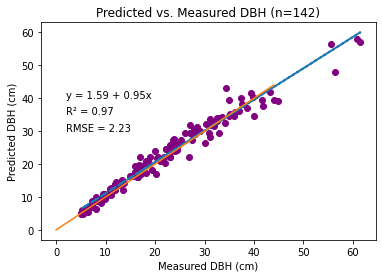

In [36]:
# make residual plot for the corelation between predicted and measure dbh values
x = np.array(df3['measured_dbh']); y = np.array( [ float(x) for x in df3['predicted_dbh']])
a, b = np.polyfit(x, y , 1)

plt.scatter(x, y, color='purple')
plt.plot(x, a*x+b, linestyle='--', linewidth=2)
plt.plot(np.arange(45), np.arange(45))
plt.xlabel("Measured DBH (cm)")
plt.ylabel("Predicted DBH (cm)")
plt.title(f"Predicted vs. Measured DBH (n={len(df3)})")

# add fitted regression equation to plot
plt.text(2, 40, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=10)

# add the r2
plt.text(2,35, f"R\u00b2 = {round(r2_score(x,y),2)} ", size=10)

# add rmse
plt.text(2,30, f"RMSE = {round(rmse,2)} ", size=10)

Text(0, 0.5, 'Frequency')

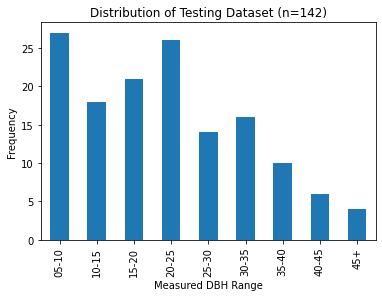

In [38]:
#Make a distribution plot for the dataset used for evaluation 
df3.groupby('range').count()['tree_picture'].plot.bar()
plt.title(f'Distribution of Testing Dataset (n={len(df3)})')
plt.xlabel("Measured DBH Range")
plt.ylabel("Frequency")

In [39]:
#df3[["measured_dbh","predicted_dbh"]].to_csv("dbh_algorithm_evaluation_dataset.csv")

In [40]:
# make a standardize residual plot for the model prediction
df3['residuals'] = df3['predicted_dbh'] - df3['measured_dbh']
# calculating the standardized residuals

import statsmodels.api as sm

#define response variable
y = df3['predicted_dbh']
y = [int(v) for v in y]

#define explanatory variable
x = df3['measured_dbh']

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit() 

#create instance of influence
influence = model.get_influence()

#obtain standardized residuals
standardized_residuals = influence.resid_studentized_internal


/var/folders/t7/8xb6r8jx3_bd842lt0tnr6sr0000gn/T/ipykernel_10466/2259229101.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['residuals'] = df3['predicted_dbh'] - df3['measured_dbh']


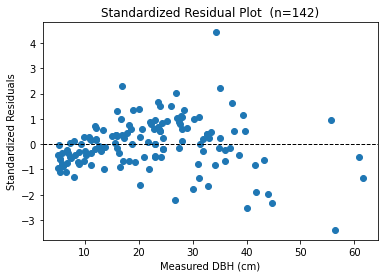

In [41]:
#plot standardized residual plot

plt.scatter(df3['measured_dbh'], standardized_residuals)
plt.xlabel('Measured DBH (cm)')
plt.ylabel('Standardized Residuals')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.title(f"Standardized Residual Plot  (n={len(df3)})")
plt.show()

In [42]:
# Make a regression model for predicted vs measured dbh values with statsmodels
import statsmodels.formula.api as smf


model = smf.ols('predicted_dbh ~ measured_dbh', data=df3)
model = model.fit()

In [43]:
# show model summary to get values for intercepts and significance at 0.05 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          predicted_dbh   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     4294.
Date:                Mon, 03 Apr 2023   Prob (F-statistic):          6.18e-107
Time:                        13:04:51   Log-Likelihood:                -305.78
No. Observations:                 142   AIC:                             615.6
Df Residuals:                     140   BIC:                             621.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.5881      0.364      4.361      0.000       0.868       2.308
measured_dbh     0.9502      0.015     65.526      0.000       0.922       0.979
==============================================================================
Omnibus:                       12.301   Durbin-Watson:                   1.626
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               32.937
Skew:                           0.133   Prob(JB):                     7.05e-08
Kurtosis:                       5.344   Cond. No.                         52.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
# save evaluation dataset
#df3[["tree_picture","predicted_dbh","measured_dbh"]].to_csv("output/dbh_algorithm_evaluation_dataset.csv")